In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# Custom Dataset Loader
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                self.images.append(os.path.join(class_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define dataset transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load custom dataset
custom_dataset = CustomDataset(root_dir="/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset", transform=transform)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Select 3 random images
indices = np.random.choice(len(custom_dataset), 3, replace=False)
images = [custom_dataset[i][0].numpy().squeeze() for i in indices]

# Apply Canny Edge Detection & Contour Detection
def canny_edge_detection(image):
    img_uint8 = (image * 255).astype(np.uint8)
    edges = cv2.Canny(img_uint8, 100, 200)
    return edges

def contour_detection(image):
    img_uint8 = (image * 255).astype(np.uint8)
    edges = cv2.Canny(img_uint8, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(img_uint8)
    cv2.drawContours(contour_img, contours, -1, (255), 1)
    return contour_img

# Define Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, num_classes=len(custom_dataset.classes)):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1, padding=0)
        self.conv2 = nn.Conv2d(256, 32 * 8, kernel_size=9, stride=2, padding=0)
        self.fc = nn.Linear(self.get_fc_input_dim(), num_classes)
    
    def get_fc_input_dim(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 128)
            x = torch.relu(self.conv1(dummy_input))
            x = torch.relu(self.conv2(x))
            return x.numel()
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Train the Capsule Network
model = CapsuleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
def train_model():
    for epoch in range(num_epochs):
        for images, labels in dataloader:
            # images = images.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_model()

KeyboardInterrupt: 

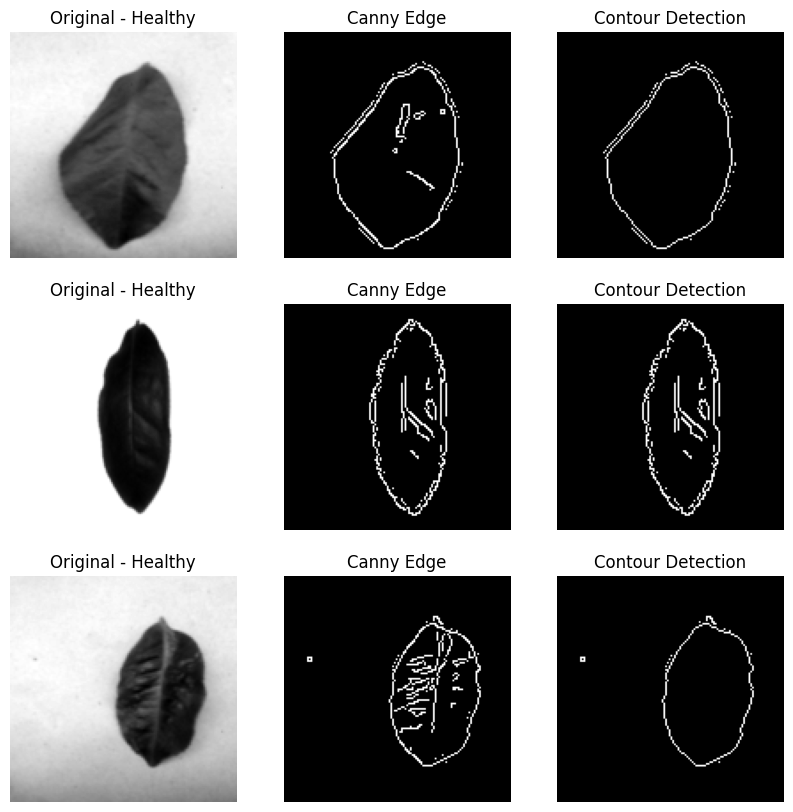

Epoch [1/5], Loss: 3.7415
Epoch [2/5], Loss: 0.1344
Epoch [3/5], Loss: 0.0634
Epoch [4/5], Loss: 0.0411
Epoch [5/5], Loss: 0.0260


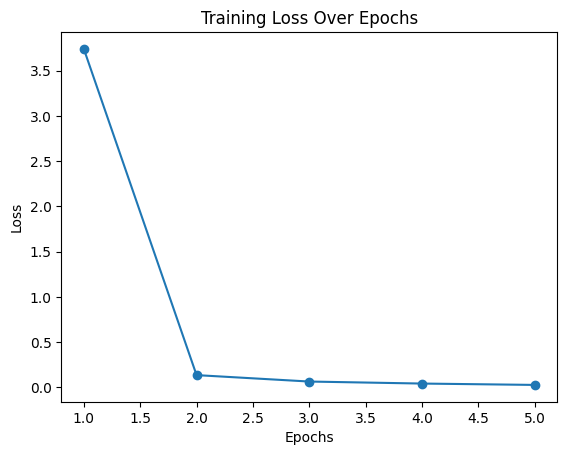

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 1, 1, 128, 128]

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# Custom Dataset Loader
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                self.images.append(os.path.join(class_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define dataset transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load custom dataset
custom_dataset = CustomDataset(root_dir="/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset", transform=transform)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Select 3 random images and visualize
indices = np.random.choice(len(custom_dataset), 3, replace=False)
images = [custom_dataset[i][0].numpy().squeeze() for i in indices]
labels = [custom_dataset[i][1] for i in indices]

def canny_edge_detection(image):
    img_uint8 = (image * 255).astype(np.uint8)
    return cv2.Canny(img_uint8, 100, 200)

def contour_detection(image):
    img_uint8 = (image * 255).astype(np.uint8)
    edges = cv2.Canny(img_uint8, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(img_uint8)
    cv2.drawContours(contour_img, contours, -1, (255), 1)
    return contour_img

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, img in enumerate(images):
    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title(f"Original - {custom_dataset.classes[labels[i]]}")
    axs[i, 1].imshow(canny_edge_detection(img), cmap='gray')
    axs[i, 1].set_title("Canny Edge")
    axs[i, 2].imshow(contour_detection(img), cmap='gray')
    axs[i, 2].set_title("Contour Detection")
for ax in axs.flat:
    ax.axis('off')
plt.show()

# Define Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, num_classes=len(custom_dataset.classes)):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1, padding=0)
        self.conv2 = nn.Conv2d(256, 32 * 8, kernel_size=9, stride=2, padding=0)
        self.fc = nn.Linear(self.get_fc_input_dim(), num_classes)
    
    def get_fc_input_dim(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 128)
            x = torch.relu(self.conv1(dummy_input))
            x = torch.relu(self.conv2(x))
            return x.numel()
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Train the Capsule Network
model = CapsuleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

def train_model():
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in dataloader:
            images = images  # Images already have the correct dimensions
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return loss_history

loss_history = train_model()
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

# Evaluate model & Generate confusion matrix
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in dataloader:
        images = images.unsqueeze(1)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=custom_dataset.classes, yticklabels=custom_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=custom_dataset.classes))

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchsummary import summary
import os

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation
def get_data_loaders(data_dir, batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
    
    print("Dataset Composition:")
    for class_name, count in zip(dataset.classes, np.bincount(dataset.targets)):
        print(f"{class_name}: {count} samples")
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, dataset.classes

# 2. Optimized Capsule Network
class CapsuleLayer(nn.Module):
    def __init__(self, in_capsules, out_capsules, in_dim, out_dim):
        super(CapsuleLayer, self).__init__()
        self.in_capsules = in_capsules
        self.out_capsules = out_capsules
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.W = nn.Parameter(torch.randn(out_capsules, in_capsules, in_dim, out_dim) * 0.01)
        
    def squash(self, s):
        sq = torch.sum(s**2, dim=-1, keepdim=True)
        return (sq / (1 + sq)) * (s / torch.sqrt(sq + 1e-9))

    def forward(self, x):
        # x shape: [batch, in_capsules, in_dim]
        # self.W shape: [out_capsules, in_capsules, in_dim, out_dim]
        # Corrected einsum: match x indices [b, n, i] with W indices [o, n, i, j]
        u = torch.einsum('bni,onij->bnoj', x, self.W)
        b = torch.zeros(x.size(0), self.in_capsules, self.out_capsules, 1, device=device)
        
        for _ in range(3):  # Routing iterations
            c = torch.softmax(b, dim=2)
            # s shape: [batch, in_capsules, out_dim]
            s = torch.einsum('bnoj,bnoj->boj', u, c)
            v = self.squash(s)
            b = b + torch.einsum('bnoj,boj->bnoj', u, v)
        
        return v

class CapsNet(nn.Module):
    def __init__(self, num_classes=5):
        super(CapsNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, 9, stride=1, padding=0)  # Output: 120x120
        self.conv2 = nn.Conv2d(128, 128, 9, stride=2, padding=0)  # Output: 56x56
        
        self.feature_size = 56
        self.num_primary_caps = 32
        self.primary_conv = nn.Conv2d(128, 32 * 8, 9, stride=1, padding=0)  # Output: 48x48x256
        
        # For primary capsules: in_capsules=32, in_dim=8, out_capsules=16, out_dim=16
        self.primary_caps = CapsuleLayer(in_capsules=32, out_capsules=16, in_dim=8, out_dim=16)
        self.class_caps = CapsuleLayer(in_capsules=16, out_capsules=num_classes, in_dim=16, out_dim=8)
        
        self.decoder = nn.Sequential(
            nn.Linear(8 * num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 128 * 3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.primary_conv(x))
        
        batch_size = x.size(0)
        # Reshape to [batch, num_capsules, capsule_dim, spatial]
        x = x.view(batch_size, self.num_primary_caps, 8, -1)
        # Average over spatial dimensions to get [batch, num_capsules, capsule_dim]
        x = x.mean(dim=3)
        
        x = self.primary_caps(x)
        x = self.class_caps(x)
        
        lengths = torch.sqrt((x**2).sum(dim=-1))
        return x, lengths

# 3. Training Function
def train_model(model, train_loader, test_loader, num_epochs=50, accum_steps=4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            target = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1.0)
            loss = criterion(outputs, target)
            loss = loss / accum_steps
            loss.backward()
            
            if (i + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            train_loss += loss.item() * accum_steps
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                _, outputs = model(images)
                target = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1.0)
                test_loss += criterion(outputs, target).item()
        
        train_losses.append(train_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
    return train_losses, test_losses

# 4. Visualization Functions
def plot_training_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.close()

def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            _, outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()

def plot_roc_pr_curves(model, test_loader, num_classes):
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            _, outputs = model(images)
            y_true.extend(labels.numpy())
            y_score.extend(outputs.cpu().numpy())
    
    y_true = np.eye(num_classes)[y_true]
    y_score = np.array(y_score)
    
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.close()
    
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig('pr_curve.png')
    plt.close()

def plot_capsule_maps(model, test_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        caps, _ = model(images)
        
        plt.figure(figsize=(15, 5))
        for i in range(min(5, caps.size(1))):
            plt.subplot(1, 5, i+1)
            plt.imshow(caps[0, i].cpu().numpy())
            plt.title(f'Capsule {i}')
        plt.savefig('capsule_maps.png')
        plt.close()

def plot_disease_distribution(test_loader, classes):
    all_labels = []
    for _, labels in test_loader:
        all_labels.extend(labels.numpy())
    
    plt.figure(figsize=(10, 6))
    plt.hist(all_labels, bins=len(classes), rwidth=0.8)
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.title('Disease Classification Distribution')
    plt.xlabel('Disease Class')
    plt.ylabel('Count')
    plt.savefig('disease_distribution.png')
    plt.close()

# 5. Main Execution
def main():
    data_dir = "/home/idrone2/Desktop/Cashew"
    train_loader, test_loader, classes = get_data_loaders(data_dir)
    model = CapsNet(num_classes=len(classes)).to(device)
    
    print("\nModel Architecture Summary:")
    summary(model, (3, 128, 128))
    
    train_losses, test_losses = train_model(model, train_loader, test_loader)
    
    plot_training_loss(train_losses, test_losses)
    plot_confusion_matrix(model, test_loader, classes)
    plot_roc_pr_curves(model, test_loader, len(classes))
    plot_capsule_maps(model, test_loader)
    plot_disease_distribution(test_loader, classes)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'\nTest Accuracy: {100 * correct / total:.2f}%')

if __name__ == "__main__":
    torch.cuda.empty_cache()
    main()


Dataset Composition:
anthracnose: 1729 samples
gumosis: 392 samples
healthy: 1368 samples
leaf miner: 1378 samples
red rust: 1682 samples

Model Architecture Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 120, 120]          31,232
            Conv2d-2          [-1, 128, 56, 56]       1,327,232
            Conv2d-3          [-1, 256, 48, 48]       2,654,464
      CapsuleLayer-4               [-1, 16, 16]               0
      CapsuleLayer-5                 [-1, 5, 8]               0
Total params: 4,012,928
Trainable params: 4,012,928
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 21.63
Params size (MB): 15.31
Estimated Total Size (MB): 37.12
----------------------------------------------------------------
Epoch [1/50], Train Loss: 0.2000, Test Loss: 0.2000
Epoch [2

KeyboardInterrupt: 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchsummary import summary
import os

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation
def get_data_loaders(data_dir, batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
    
    print("Dataset Composition:")
    for class_name, count in zip(dataset.classes, np.bincount(dataset.targets)):
        print(f"{class_name}: {count} samples")
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, dataset.classes

# 2. Optimized Capsule Network
class CapsuleLayer(nn.Module):
    def __init__(self, in_capsules, out_capsules, in_dim, out_dim):
        super(CapsuleLayer, self).__init__()
        self.in_capsules = in_capsules
        self.out_capsules = out_capsules
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.W = nn.Parameter(torch.randn(out_capsules, in_capsules, in_dim, out_dim) * 0.1)
        
    def squash(self, s):
        sq = torch.sum(s**2, dim=-1, keepdim=True)
        return (sq / (1 + sq)) * (s / torch.sqrt(sq + 1e-9))

    def forward(self, x):
        u = torch.einsum('bni,onij->bnoj', x, self.W)
        b = torch.zeros(x.size(0), self.in_capsules, self.out_capsules, 1, device=device)
        
        for _ in range(5):
            c = torch.softmax(b, dim=2)
            s = torch.einsum('bnoj,bnoj->boj', u, c)
            v = self.squash(s)
            b = b + torch.einsum('bnoj,boj->bnoj', u, v)
        
        return v, c

class CapsNet(nn.Module):
    def __init__(self, num_classes=5):
        super(CapsNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, 9, stride=1, padding=0)
        self.conv2 = nn.Conv2d(128, 128, 9, stride=2, padding=0)
        
        self.num_primary_caps = 32
        self.primary_conv = nn.Conv2d(128, 32 * 8, 9, stride=1, padding=0)
        
        self.primary_caps = CapsuleLayer(in_capsules=32, out_capsules=16, in_dim=8, out_dim=16)
        self.class_caps = CapsuleLayer(in_capsules=16, out_capsules=num_classes, in_dim=16, out_dim=8)
        
        self.decoder = nn.Sequential(
            nn.Linear(8 * num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 128 * 3),
            nn.Sigmoid()
        )
        self.num_classes = num_classes
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.primary_conv(x))
        
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_primary_caps, 8, -1).mean(dim=3)
        
        x, _ = self.primary_caps(x)
        x, c = self.class_caps(x)
        
        lengths = torch.sqrt((x**2).sum(dim=-1))
        return x, lengths, c

# Wrapper for torchsummary compatibility
# class CapsNetSummaryWrapper(nn.Module):
#     def __init__(self, model):
#         super(CapsNetSummaryWrapper, self).__init__()
#         self.model = model
    
#     def forward(self, x):
#         # Just return the output lengths as a single tensor with consistent shape
#         _, lengths, _ = self.model(x)
#         return lengths
    
    # def forward(self, x):
    #     # Explicitly run the forward pass and return only lengths
    #     conv1_out = torch.relu(self.model.conv1(x))
    #     conv2_out = torch.relu(self.model.conv2(conv1_out))
    #     primary_conv_out = torch.relu(self.model.primary_conv(conv2_out))
        
    #     batch_size = primary_conv_out.size(0)
    #     x = primary_conv_out.view(batch_size, self.model.num_primary_caps, 8, -1).mean(dim=3)
        
    #     x, _ = self.model.primary_caps(x)
    #     x, _ = self.model.class_caps(x)
        
    #     lengths = torch.sqrt((x**2).sum(dim=-1))
    #     return lengths  # Return only lengths as a single tensor

# 3. Margin Loss Function
def margin_loss(outputs, labels, m_plus=0.9, m_minus=0.1, lambda_=0.5):
    batch_size = outputs.size(0)
    T = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1.0)
    
    loss_pos = torch.sum(T * torch.clamp(m_plus - outputs, min=0) ** 2)
    loss_neg = torch.sum((1 - T) * torch.clamp(outputs - m_minus, min=0) ** 2)
    loss = (loss_pos + lambda_ * loss_neg) / batch_size
    return loss

# 4. Training Function with Accuracy Tracking
def train_model(model, train_loader, test_loader, num_epochs=50, accum_steps=4):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        optimizer.zero_grad()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            _, outputs, _ = model(images)
            loss = margin_loss(outputs, labels) / accum_steps
            loss.backward()
            
            if (i + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            train_loss += loss.item() * accum_steps
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                _, outputs, _ = model(images)
                test_loss += margin_loss(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        train_accuracies.append(100 * train_correct / train_total)
        test_accuracies.append(100 * test_correct / test_total)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
              f'Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%')
        scheduler.step()
    
    return train_losses, test_losses, train_accuracies, test_accuracies

# 5. Visualization Functions
def plot_accuracy_vs_epochs(train_accuracies, test_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.savefig('accuracy_vs_epochs.png')
    plt.close()

def plot_training_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.close()

def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            _, outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()

def plot_roc_pr_curves(model, test_loader, num_classes):
    model.eval()
    y_true, y_score = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            _, outputs, _ = model(images)
            y_true.extend(labels.numpy())
            y_score.extend(outputs.cpu().numpy())
    
    y_true = np.eye(num_classes)[y_true]
    y_score = np.array(y_score)
    
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.close()
    
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig('pr_curve.png')
    plt.close()

def plot_capsule_maps(model, test_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        caps, _, _ = model(images)
        
        plt.figure(figsize=(15, 5))
        for i in range(min(5, caps.size(1))):
            plt.subplot(1, 5, i+1)
            plt.bar(range(caps.size(2)), caps[0, i].cpu().numpy())
            plt.title(f'Capsule {i}')
            plt.xlabel('Dim')
            plt.ylabel('Activation')
        plt.tight_layout()
        plt.savefig('capsule_maps.png')
        plt.close()

def plot_attention_weights(model, test_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        _, _, c = model(images)
        
        attention = c.mean(dim=0).mean(dim=-1).cpu().numpy()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(attention, cmap='viridis', annot=True, fmt='.2f')
        plt.title('Attention Weight Map (Class Capsules vs. Primary Capsules)')
        plt.xlabel('Primary Capsules')
        plt.ylabel('Class Capsules')
        plt.savefig('attention_weights.png')
        plt.close()

def plot_disease_distribution(test_loader, classes):
    all_labels = []
    for _, labels in test_loader:
        all_labels.extend(labels.numpy())
    
    plt.figure(figsize=(10, 6))
    plt.hist(all_labels, bins=len(classes), rwidth=0.8)
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.title('Disease Classification Distribution')
    plt.xlabel('Disease Class')
    plt.ylabel('Count')
    plt.savefig('disease_distribution.png')
    plt.close()

# 6. Main Execution
def main():
    data_dir = "/home/idrone2/Desktop/Cashew"
    train_loader, test_loader, classes = get_data_loaders(data_dir)
    model = CapsNet(num_classes=len(classes)).to(device)
    
    # Use wrapper for summary
   # print("\nModel Architecture Summary:")
    #summary_model = CapsNetSummaryWrapper(model).to(device)
    #summary(summary_model, (3, 128, 128))
    
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader)
    
    plot_accuracy_vs_epochs(train_accuracies, test_accuracies)
    plot_training_loss(train_losses, test_losses)
    plot_confusion_matrix(model, test_loader, classes)
    plot_roc_pr_curves(model, test_loader, len(classes))
    plot_capsule_maps(model, test_loader)
    plot_attention_weights(model, test_loader)
    plot_disease_distribution(test_loader, classes)
    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            _, outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'\nFinal Test Accuracy: {100 * correct / total:.2f}%')

if __name__ == "__main__":
    torch.cuda.empty_cache()
    main()

Dataset Composition:
anthracnose: 1729 samples
gumosis: 392 samples
healthy: 1368 samples
leaf miner: 1378 samples
red rust: 1682 samples
Epoch [1/50], Train Loss: 0.4264, Test Loss: 0.4030, Train Acc: 27.39%, Test Acc: 26.03%
Epoch [2/50], Train Loss: 0.4074, Test Loss: 0.4045, Train Acc: 26.11%, Test Acc: 26.72%
Epoch [3/50], Train Loss: 0.4029, Test Loss: 0.3925, Train Acc: 29.53%, Test Acc: 34.81%
Epoch [4/50], Train Loss: 0.3939, Test Loss: 0.3855, Train Acc: 33.80%, Test Acc: 35.34%
Epoch [5/50], Train Loss: 0.3967, Test Loss: 0.3953, Train Acc: 32.51%, Test Acc: 26.11%
Epoch [6/50], Train Loss: 0.3975, Test Loss: 0.3921, Train Acc: 31.82%, Test Acc: 33.82%
Epoch [7/50], Train Loss: 0.3915, Test Loss: 0.3840, Train Acc: 34.15%, Test Acc: 34.66%
Epoch [8/50], Train Loss: 0.3857, Test Loss: 0.3954, Train Acc: 35.18%, Test Acc: 31.98%
Epoch [9/50], Train Loss: 0.3892, Test Loss: 0.3964, Train Acc: 34.49%, Test Acc: 31.07%
Epoch [10/50], Train Loss: 0.3963, Test Loss: 0.3907, Train A

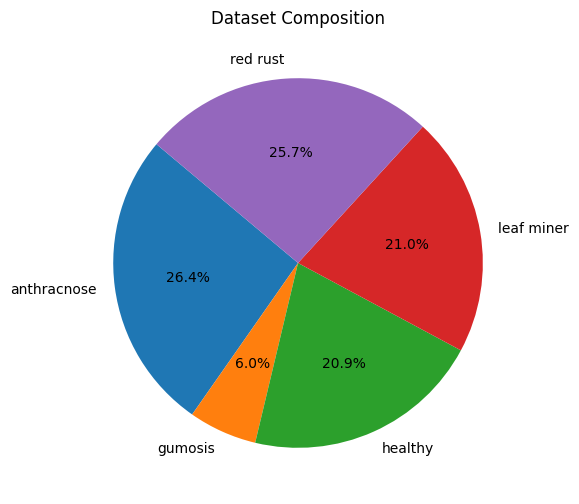

Model Architecture:
CapsNet(
  (conv1): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  (primary_capsules): CapsuleLayer(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): CapsuleLayer()
)

Total Trainable Parameters: 1515320576


Epoch 1:   0%|          | 0/164 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from torch.cuda.amp import GradScaler, autocast

# ================================
# CONFIGURATION
# ================================
class Config:
    def __init__(self, input_size=(400, 400), num_classes=10):
        self.input_width, self.input_height = input_size
        self.num_classes = num_classes

        # Convolutional layer parameters
        self.cnn_in_channels = 3  # RGB images assumed
        self.cnn_out_channels = 256
        self.cnn_kernel_size = 9  # conv1 kernel size

        # After conv1:
        #   output size = (input_size - kernel_size + 1)
        conv1_out_dim = input_size[0] - self.cnn_kernel_size + 1  # 400-9+1 = 392

        # Primary Capsule layer parameters
        self.pc_num_capsules = 8  # number of capsule types
        self.pc_in_channels = self.cnn_out_channels  # should match conv1 out channels
        self.pc_out_channels = 32
        self.pc_kernel_size = 9
        self.pc_stride = 2
        # Output spatial dimension for primary capsule layer:
        #   primary_out = floor((conv1_out_dim - pc_kernel_size)/stride + 1)
        primary_out_dim = (conv1_out_dim - self.pc_kernel_size) // self.pc_stride + 1  # e.g. 192

        # Number of routes for digit capsules:
        # Each capsule in digit capsule receives input from all primary capsule outputs.
        # Here, we assume each convolutional capsule produces an output of shape:
        #   [batch, pc_out_channels, primary_out_dim, primary_out_dim]
        # Then we flatten over spatial dimensions.
        self.pc_num_routes = self.pc_out_channels * (primary_out_dim ** 2)  # e.g. 32 * 192^2

        # Digit Capsule (final capsule) layer parameters
        self.dc_num_capsules = num_classes  # one capsule per class
        self.dc_num_routes = self.pc_num_routes  # same as above
        self.dc_in_channels = self.pc_num_capsules  # each primary capsule's vector dimension (8)
        self.dc_out_channels = 16  # output dimension of each digit capsule

# ================================
# CAPSULE NETWORK IMPLEMENTATION
# ================================
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels, kernel_size=None, stride=None):
        """
        If num_routes == -1, applies a convolutional capsule layer (for Primary Capsules).
        Otherwise, applies dynamic routing (for Digit Capsules).
        """
        super(CapsuleLayer, self).__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        if num_routes != -1:
            # Digit capsule layer uses dynamic routing.
            # route_weights shape: [num_capsules, num_routes, in_channels, out_channels]
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))
        else:
            # Primary capsule layer: a set of convolutional units.
            self.capsules = nn.ModuleList([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0)
                for _ in range(num_capsules)
            ])

    def forward(self, x, return_attention=False):
        if self.num_routes != -1:
            # x expected shape: [batch, num_routes, in_channels]
            # Compute "priors" via matrix multiplication.
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]
            # priors shape: [num_capsules, batch, num_routes, 1, out_channels]
            logits = torch.zeros(*priors.size()).cuda()
            # Dynamic routing (3 iterations)
            for i in range(3):
                probs = F.softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))
                if i != 2:
                    logits = logits + (priors * outputs).sum(dim=-1, keepdim=True)
            if return_attention:
                return outputs, probs
            else:
                return outputs
        else:
            # Primary capsule layer: perform convolution for each capsule type.
            # Each capsule produces an output of shape [batch, out_channels, H, W]
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            # Concatenate along the last dimension -> shape: [batch, num_routes, num_capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)
            return outputs

    def squash(self, x, dim=-1):
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm + 1e-8)

class CapsNet(nn.Module):
    def __init__(self, config):
        super(CapsNet, self).__init__()
        self.config = config
        # Convolution layer
        self.conv1 = nn.Conv2d(in_channels=config.cnn_in_channels,
                               out_channels=config.cnn_out_channels,
                               kernel_size=config.cnn_kernel_size,
                               stride=1)
        # Primary Capsules (convolutional capsule layer)
        self.primary_capsules = CapsuleLayer(num_capsules=config.pc_num_capsules,
                                             num_routes=-1,
                                             in_channels=config.pc_in_channels,
                                             out_channels=config.pc_out_channels,
                                             kernel_size=config.pc_kernel_size,
                                             stride=config.pc_stride)
        # Digit Capsules (with dynamic routing)
        self.digit_capsules = CapsuleLayer(num_capsules=config.dc_num_capsules,
                                           num_routes=config.pc_num_routes,
                                           in_channels=config.dc_in_channels,
                                           out_channels=config.dc_out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        primary_out = self.primary_capsules(x)
        # For digit capsules, we expect input shape [batch, num_routes, in_channels]
        digit_out = self.digit_capsules(primary_out)
        # Remove extra dimensions and transpose so shape becomes [batch, num_capsules, out_channels]
        digit_out = digit_out.squeeze().transpose(0, 1)
        # Compute length (norm) of each capsule's output vector as class scores.
        classes = torch.sqrt((digit_out ** 2).sum(dim=-1) + 1e-8)
        return F.softmax(classes, dim=-1)

    def forward_with_attention(self, x):
        """
        Same as forward but returns the attention weights from the digit capsules.
        """
        x = F.relu(self.conv1(x), inplace=True)
        primary_out = self.primary_capsules(x)
        digit_out, attention = self.digit_capsules(primary_out, return_attention=True)
        digit_out = digit_out.squeeze().transpose(0, 1)
        classes = torch.sqrt((digit_out ** 2).sum(dim=-1) + 1e-8)
        return F.softmax(classes, dim=-1), attention

# ================================
# DATA LOADER & DATASET COMPOSITION PLOT
# ================================
class CustomDataset:
    def __init__(self, data_path, batch_size, img_size=(400, 400), train_split=0.8, num_workers=4):
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_dataset = datasets.ImageFolder(root=data_path, transform=self.transform)
        train_size = int(train_split * len(full_dataset))
        test_size = len(full_dataset) - train_size
        self.train_data, self.test_data = random_split(full_dataset, [train_size, test_size])
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True,
                                       pin_memory=True, num_workers=num_workers)
        self.test_loader = DataLoader(self.test_data, batch_size=batch_size, shuffle=False,
                                      pin_memory=True, num_workers=num_workers)
        self.classes = full_dataset.classes
        self.full_dataset = full_dataset

def plot_dataset_composition(dataset):
    counts = {}
    for _, label in dataset:
        counts[label] = counts.get(label, 0) + 1
    labels = list(counts.keys())
    counts_list = [counts[l] for l in labels]
    class_names = [dataset.classes[l] for l in labels]
    plt.figure(figsize=(6, 6))
    plt.pie(counts_list, labels=class_names, autopct='%1.1f%%', startangle=140)
    plt.title("Dataset Composition")
    plt.show()

# ================================
# ADDITIONAL VISUALIZATION FUNCTIONS
# ================================

def plot_capsule_map(model, image):
    """
    Visualize the capsule map from the primary capsules.
    For each capsule type, we compute the norm of its output over the channels.
    """
    model.eval()
    with torch.no_grad():
        # Pass through conv1
        x = F.relu(model.conv1(image.unsqueeze(0).cuda()), inplace=True)
        # For each primary capsule (convolutional layer) in model.primary_capsules
        capsule_maps = []
        for idx, capsule in enumerate(model.primary_capsules.capsules):
            out = capsule(x)  # shape: [1, out_channels, H, W]
            # Compute norm across the channel dimension
            norm_map = torch.sqrt((out ** 2).sum(dim=1)).squeeze().cpu().numpy()
            capsule_maps.append(norm_map)
    
    num_capsules = len(capsule_maps)
    plt.figure(figsize=(15, 4))
    for i in range(num_capsules):
        plt.subplot(1, num_capsules, i+1)
        plt.imshow(capsule_maps[i], cmap='viridis')
        plt.title(f'Capsule {i}')
        plt.axis('off')
    plt.suptitle("Primary Capsule Maps")
    plt.show()

def plot_attention_weights(model, image):
    """
    Visualize the attention weights from the digit capsule layer.
    The attention weights (from dynamic routing) are averaged over the output capsule dimension
    and then reshaped to the spatial grid of primary capsules.
    """
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).cuda()
        _, attention = model.forward_with_attention(image)
        # attention shape: [dc_num_capsules, batch, num_routes, 1, dc_out_channels]
        # We take the first (and only) item in batch, and average over dc_out_channels:
        attention = attention[:, 0, :, 0, :].mean(dim=-1)  # shape: [dc_num_capsules, num_routes]
        
        # We know num_routes = pc_out_channels * (primary_out_dim^2)
        # We recover primary_out_dim using config: primary_out_dim = sqrt(num_routes / pc_out_channels)
        num_routes = attention.shape[1]
        pc_out_channels = model.config.pc_out_channels
        primary_out_dim = int(np.sqrt(num_routes / pc_out_channels))
        # For each digit capsule (class capsule), reshape the attention weights to [pc_out_channels, primary_out_dim, primary_out_dim]
        plt.figure(figsize=(15, 4))
        for i in range(attention.shape[0]):
            att = attention[i].reshape(pc_out_channels, primary_out_dim, primary_out_dim)
            # Average over the pc_out_channels to get a single heatmap
            att_map = att.mean(dim=0).cpu().numpy()
            plt.subplot(1, attention.shape[0], i+1)
            sns.heatmap(att_map, cmap='viridis', cbar=False)
            plt.title(f'Class Capsule {i}')
            plt.axis('off')
        plt.suptitle("Attention Weights from Digit Capsules")
        plt.show()

def plot_disease_distribution(y_pred, class_names):
    """
    Plot a pie chart of the predicted class (disease) distribution.
    """
    counts = {}
    for label in y_pred:
        counts[label] = counts.get(label, 0) + 1
    labels = list(counts.keys())
    counts_list = [counts[l] for l in labels]
    names = [class_names[l] for l in labels]
    plt.figure(figsize=(6, 6))
    plt.pie(counts_list, labels=names, autopct='%1.1f%%', startangle=140)
    plt.title("Disease Distribution (Predictions)")
    plt.show()

# ================================
# TRAINING & EVALUATION WITH MEMORY OPTIMIZATION (AMP)
# ================================
def train(model, train_loader, optimizer, epochs=10):
    model.train()
    history = {'loss': [], 'accuracy': []}
    scaler = GradScaler()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = F.cross_entropy(output, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            correct += (output.argmax(dim=1) == target).sum().item()
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / len(train_loader.dataset)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")
    return history

def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], marker='o', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], marker='o', label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()

def plot_roc_pr(y_true, y_probs, num_classes):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.subplot(1, 2, 2)
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate(model, test_loader, num_classes):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            y_probs.extend(output.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    plot_roc_pr(y_true, np.array(y_probs), num_classes)
    return y_true, y_pred, y_probs

# ================================
# ARCHITECTURAL DETAILS & PARAMETER COUNT
# ================================
def print_model_summary(model):
    print("Model Architecture:")
    print(model)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {total_params}")

# ================================
# MAIN EXECUTION
# ================================
if __name__ == "__main__":
    # Replace with your dataset path (organized in ImageFolder format)
    data_path = "/home/idrone2/Desktop/Cashew"  
    batch_size = 32  # using batch size 32
    num_epochs = 10

    config = Config(input_size=(400, 400), num_classes=10)
    dataset = CustomDataset(data_path, batch_size, img_size=(400, 400))
    
    # Plot dataset composition (overall)
    plot_dataset_composition(dataset.full_dataset)
    
    # Instantiate model and print its summary
    model = CapsNet(config).cuda()
    print_model_summary(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = train(model, dataset.train_loader, optimizer, epochs=num_epochs)
    plot_metrics(history)
    
    # Evaluate model and get predictions for disease distribution
    y_true, y_pred, y_probs = evaluate(model, dataset.test_loader, num_classes=config.num_classes)
    plot_disease_distribution(y_pred, dataset.classes)
    
    # Visualize Capsule Map & Attention Weights on a single sample from test set
    sample_img, sample_label = dataset.test_data[0]
    plot_capsule_map(model, sample_img)
    plot_attention_weights(model, sample_img)


Configuring model with memory optimizations...
Loading dataset...


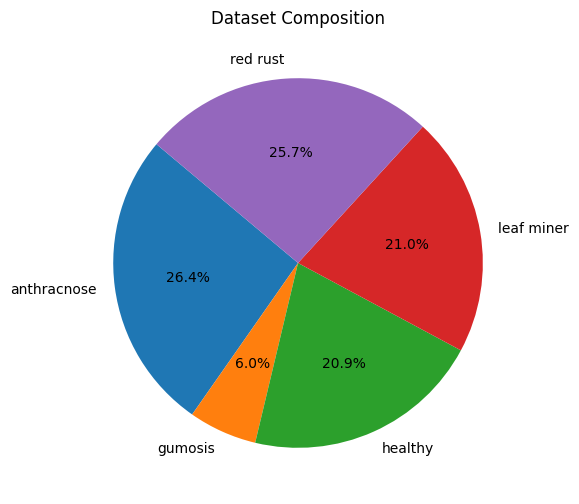

Creating model...
Model Architecture: CapsNet
Total Trainable Parameters: 1,213,330,688
Initial GPU memory state:
GPU Memory Usage:
  Device 0: 10302.33 MB Allocated, 10314.00 MB Reserved
Starting training...
GPU Memory Usage:
  Device 0: 10302.33 MB Allocated, 10314.00 MB Reserved


Epoch 1:   0%|          | 0/1310 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 144.00 MiB. GPU 

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from torch.cuda.amp import GradScaler, autocast
import torch.utils.checkpoint as checkpoint  # For gradient checkpointing
import gc  # For garbage collection

# ================================
# CONFIGURATION
# ================================
class Config:
    def __init__(self, input_size=(400, 400), num_classes=8, batch_size=16):
        self.input_width, self.input_height = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size  # Added batch size to config

        # Convolutional layer parameters
        self.cnn_in_channels = 3  # RGB images assumed
        self.cnn_out_channels = 256
        self.cnn_kernel_size = 9  # conv1 kernel size

        conv1_out_dim = input_size[0] - self.cnn_kernel_size + 1  # e.g. 400-9+1 = 392

        # Primary Capsule layer parameters
        self.pc_num_capsules = 8  # number of capsule types
        self.pc_in_channels = self.cnn_out_channels  # should match conv1 out channels
        self.pc_out_channels = 32
        self.pc_kernel_size = 9
        self.pc_stride = 2
        primary_out_dim = (conv1_out_dim - self.pc_kernel_size) // self.pc_stride + 1  # e.g. 192

        # Number of routes (flattened spatial dimensions times channels)
        self.pc_num_routes = self.pc_out_channels * (primary_out_dim ** 2)

        # Digit Capsule layer parameters
        self.dc_num_capsules = num_classes
        self.dc_num_routes = self.pc_num_routes
        self.dc_in_channels = self.pc_num_capsules  # vector dim from primary capsules
        self.dc_out_channels = 16

# ================================
# CAPSULE NETWORK IMPLEMENTATION
# ================================
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels, kernel_size=None, stride=None):
        super(CapsuleLayer, self).__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        if num_routes != -1:
            # Initialize with smaller values to improve numerical stability
            self.route_weights = nn.Parameter(
                torch.randn(num_capsules, num_routes, in_channels, out_channels) * 0.01
            )
        else:
            self.capsules = nn.ModuleList([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0)
                for _ in range(num_capsules)
            ])

    def forward(self, x, return_attention=False):
        if self.num_routes != -1:
            # x shape: [batch, num_routes, in_channels]
            # Expand x: [1, batch, num_routes, 1, in_channels]
            x_expanded = x[None, :, :, None, :]
            batch_size = x.size(0)
            outputs_shape = (self.num_capsules, batch_size, 1, 1, self.route_weights.size(-1))
            outputs = torch.zeros(outputs_shape, dtype=x.dtype, device=x.device)
            logits = torch.zeros(self.num_capsules, batch_size, self.num_routes, 1, 1, device=x.device)
            
            # Dynamic routing: process in chunks to save memory
            for i in range(3):
                probs = F.softmax(logits, dim=2)
                chunk_size = max(1, self.num_routes // 4)  # adjust chunk size as needed
                for start_idx in range(0, self.num_routes, chunk_size):
                    end_idx = min(start_idx + chunk_size, self.num_routes)
                    # x_chunk: [1, batch, chunk, 1, in_channels]
                    x_chunk = x_expanded[:, :, start_idx:end_idx, :, :]
                    # Repeat along first dimension to match num_capsules:
                    x_chunk = x_chunk.repeat(self.num_capsules, 1, 1, 1, 1)  # shape: [num_capsules, batch, chunk, 1, in_channels]
                    # weights_chunk: [num_capsules, chunk, in_channels, out_channels]
                    weights_chunk = self.route_weights[:, start_idx:end_idx, :, :]
                    # probs_chunk: [num_capsules, batch, chunk, 1, 1]
                    probs_chunk = probs[:, :, start_idx:end_idx, :, :]
                    
                    # Direct matrix multiplication without checkpointing:
                    priors_chunk = torch.matmul(x_chunk, weights_chunk)
                    # priors_chunk shape: [num_capsules, batch, chunk, 1, out_channels]
                    
                    weighted_priors = probs_chunk * priors_chunk
                    chunk_sum = weighted_priors.sum(dim=2, keepdim=True)
                    outputs += chunk_sum
                    
                    if i != 2:
                        logits_update = (priors_chunk * outputs.unsqueeze(2)).sum(dim=-1, keepdim=True)
                        logits[:, :, start_idx:end_idx, :, :] += logits_update
                        del logits_update
                    del x_chunk, weights_chunk, probs_chunk, priors_chunk, weighted_priors, chunk_sum
                    torch.cuda.empty_cache()
                outputs = self.squash(outputs)
            
            if return_attention:
                return outputs, probs
            else:
                return outputs
        else:
            outputs = []
            for capsule in self.capsules:
                capsule_out = checkpoint.checkpoint(capsule, x)
                outputs.append(capsule_out.view(x.size(0), -1, 1))
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)
            return outputs

    def squash(self, x, dim=-1):
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / (torch.sqrt(squared_norm + 1e-8))

class CapsNet(nn.Module):
    def __init__(self, config):
        super(CapsNet, self).__init__()
        self.config = config
        self.conv1 = nn.Conv2d(in_channels=config.cnn_in_channels,
                               out_channels=config.cnn_out_channels,
                               kernel_size=config.cnn_kernel_size,
                               stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=config.pc_num_capsules,
                                             num_routes=-1,
                                             in_channels=config.pc_in_channels,
                                             out_channels=config.pc_out_channels,
                                             kernel_size=config.pc_kernel_size,
                                             stride=config.pc_stride)
        self.digit_capsules = CapsuleLayer(num_capsules=config.dc_num_capsules,
                                           num_routes=config.pc_num_routes,
                                           in_channels=config.dc_in_channels,
                                           out_channels=config.dc_out_channels)

    def forward(self, x):
        # Use gradient checkpointing for conv1
        x = checkpoint.checkpoint(self.conv1, x)
        x = F.relu(x, inplace=True)
        primary_out = checkpoint.checkpoint(self.primary_capsules, x)
        digit_out = checkpoint.checkpoint(self.digit_capsules, primary_out)
        digit_out = digit_out.squeeze().transpose(0, 1)
        classes = torch.sqrt((digit_out ** 2).sum(dim=-1) + 1e-8)
        return F.softmax(classes, dim=-1)

    def forward_with_attention(self, x):
        x = checkpoint.checkpoint(self.conv1, x)
        x = F.relu(x, inplace=True)
        primary_out = checkpoint.checkpoint(self.primary_capsules, x)
        def get_digit_out_with_attention(primary_out):
            return self.digit_capsules(primary_out, return_attention=True)
        digit_out, attention = checkpoint.checkpoint(get_digit_out_with_attention, primary_out)
        digit_out = digit_out.squeeze().transpose(0, 1)
        classes = torch.sqrt((digit_out ** 2).sum(dim=-1) + 1e-8)
        return F.softmax(classes, dim=-1), attention

# ================================
# DATA LOADER & DATASET COMPOSITION PLOT
# ================================
class CustomDataset:
    def __init__(self, data_path, batch_size, img_size=(400, 400), train_split=0.8, num_workers=2):
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_dataset = datasets.ImageFolder(root=data_path, transform=self.transform)
        train_size = int(train_split * len(full_dataset))
        test_size = len(full_dataset) - train_size
        self.train_data, self.test_data = random_split(full_dataset, [train_size, test_size])
        self.train_loader = DataLoader(
            self.train_data, 
            batch_size=batch_size, 
            shuffle=True,
            pin_memory=True, 
            num_workers=num_workers,
            persistent_workers=True if num_workers > 0 else False,
            prefetch_factor=2 if num_workers > 0 else None
        )
        self.test_loader = DataLoader(
            self.test_data, 
            batch_size=batch_size, 
            shuffle=False,
            pin_memory=True, 
            num_workers=num_workers,
            persistent_workers=True if num_workers > 0 else False,
            prefetch_factor=2 if num_workers > 0 else None
        )
        self.classes = full_dataset.classes
        self.full_dataset = full_dataset

def plot_dataset_composition(dataset):
    counts = {}
    for _, label in dataset:
        counts[label] = counts.get(label, 0) + 1
    labels = list(counts.keys())
    counts_list = [counts[l] for l in labels]
    class_names = [dataset.classes[l] for l in labels]
    plt.figure(figsize=(6, 6))
    plt.pie(counts_list, labels=class_names, autopct='%1.1f%%', startangle=140)
    plt.title("Dataset Composition")
    plt.show()

# ================================
# MEMORY USAGE MONITORING
# ================================
def print_gpu_memory_stats():
    if torch.cuda.is_available():
        print("GPU Memory Usage:")
        for i in range(torch.cuda.device_count()):
            allocated = torch.cuda.memory_allocated(i) / (1024 * 1024)
            reserved = torch.cuda.memory_reserved(i) / (1024 * 1024)
            print(f"  Device {i}: {allocated:.2f} MB Allocated, {reserved:.2f} MB Reserved")
    else:
        print("CUDA not available")

# ================================
# TRAINING & EVALUATION WITH MEMORY OPTIMIZATION (AMP)
# ================================
def train(model, train_loader, optimizer, epochs=10):
    model.train()
    history = {'loss': [], 'accuracy': []}
    scaler = GradScaler()
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        
        gc.collect()
        torch.cuda.empty_cache()
        print_gpu_memory_stats()
        
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad(set_to_none=True)
            
            with autocast():
                output = model(data)
                if output.size(1) != target.size(1):
                    target = target.view(-1, output.size(1))
                loss = F.cross_entropy(output, target)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.detach().item()
            correct += (output.detach().argmax(dim=1) == target).sum().item()
            
            del data, target, output, loss
            torch.cuda.empty_cache()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / len(train_loader.dataset)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")
        print_gpu_memory_stats()
        
        gc.collect()
        torch.cuda.empty_cache()
    
    return history

def evaluate(model, test_loader, num_classes):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    
    gc.collect()
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            y_probs.extend(output.cpu().numpy())
            del data, target, output
            torch.cuda.empty_cache()
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    plot_roc_pr(y_true, np.array(y_probs), num_classes)
    
    return y_true, y_pred, y_probs

def plot_roc_pr(y_true, y_probs, num_classes):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], marker='o', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], marker='o', label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()

# ================================
# MAIN EXECUTION
# ================================
if __name__ == "__main__":
    data_path = "/home/idrone2/Desktop/Cashew"  # Update with your dataset path
    batch_size = 4  # Further reduced batch size to avoid CUDA out of memory error
    num_epochs = 10
    
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
    
    print("Configuring model with memory optimizations...")
    config = Config(input_size=(400, 400), num_classes=8, batch_size=batch_size)
    
    print("Loading dataset...")
    dataset = CustomDataset(data_path, batch_size, img_size=(400, 400), num_workers=2)
    
    plot_dataset_composition(dataset.full_dataset)
    
    print("Creating model...")
    model = CapsNet(config).cuda()
    
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model Architecture: CapsNet")
    print(f"Total Trainable Parameters: {total_params:,}")
    
    print("Initial GPU memory state:")
    print_gpu_memory_stats()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    print("Starting training...")
    history = train(model, dataset.train_loader, optimizer, epochs=num_epochs)
    plot_metrics(history)
    
    print("Evaluating model...")
    y_true, y_pred, y_probs = evaluate(model, dataset.test_loader, num_classes=config.num_classes)
    
    from collections import Counter
    class_counts = Counter(y_pred)
    counts = [class_counts[i] for i in range(config.num_classes)]
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=dataset.classes, autopct='%1.1f%%', startangle=140)
    plt.title("Disease Distribution (Predictions)")
    plt.show()
    
    torch.save(model.state_dict(), "capsnet_model.pth")
    
    gc.collect()
    torch.cuda.empty_cache()
    print_gpu_memory_stats()
    
    # Additional visualizations for a sample from the test set can be added here.


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.utils.checkpoint as checkpoint
import gc

# ================================
# CONFIGURATION
# ================================
class Config:
    def __init__(self, input_size=(224, 224), num_classes=8, batch_size=2):
        self.input_width, self.input_height = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.cnn_in_channels = 3
        self.cnn_out_channels = 128
        self.cnn_kernel_size = 7
        conv1_out_dim = input_size[0] - self.cnn_kernel_size + 1

        self.pc_num_capsules = 4
        self.pc_in_channels = self.cnn_out_channels
        self.pc_out_channels = 16
        self.pc_kernel_size = 7
        self.pc_stride = 2
        primary_out_dim = (conv1_out_dim - self.pc_kernel_size) // self.pc_stride + 1
        self.pc_num_routes = self.pc_out_channels * (primary_out_dim ** 2)

        self.dc_num_capsules = num_classes
        self.dc_num_routes = self.pc_num_routes
        self.dc_in_channels = self.pc_num_capsules
        self.dc_out_channels = 8

# ================================
# CAPSULE NETWORK IMPLEMENTATION
# ================================
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels, kernel_size=None, stride=None):
        super(CapsuleLayer, self).__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        if num_routes != -1:  # DigitCaps
            self.route_weights = nn.Parameter(
                torch.randn(num_capsules, num_routes, in_channels, out_channels) * 0.01
            )
        else:  # PrimaryCaps
            self.capsules = nn.ModuleList([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0)
                for _ in range(num_capsules)
            ])

    def forward(self, x, return_attention=False):
        if self.num_routes != -1:  # DigitCaps layer
            batch_size = x.size(0)
            # x: [batch_size, num_routes, in_channels]
            x_expanded = x[:, None, :, :, None]  # [batch_size, 1, num_routes, in_channels, 1]
            weights = self.route_weights  # [num_capsules, num_routes, in_channels, out_channels]
            
            # Expand x to match num_capsules
            x_expanded = x_expanded.expand(-1, self.num_capsules, -1, -1, -1)  # [batch_size, num_capsules, num_routes, in_channels, 1]
            
            # Compute priors: [batch_size, num_capsules, num_routes, 1, out_channels]
            priors = torch.matmul(x_expanded, weights.unsqueeze(0))  # Broadcasting handles the matmul
            
            # Dynamic routing
            logits = torch.zeros(batch_size, self.num_capsules, self.num_routes, 1, 1, device=x.device)
            for i in range(3):  # 3 routing iterations
                probs = F.softmax(logits, dim=2)  # [batch_size, num_capsules, num_routes, 1, 1]
                outputs = (probs * priors).sum(dim=2, keepdim=True)  # [batch_size, num_capsules, 1, 1, out_channels]
                outputs = self.squash(outputs)
                
                if i != 2:  # Update logits except on last iteration
                    logits += (priors * outputs).sum(dim=-1, keepdim=True)  # [batch_size, num_capsules, num_routes, 1, 1]
            
            outputs = outputs.squeeze(2).squeeze(2)  # [batch_size, num_capsules, out_channels]
            if return_attention:
                return outputs, probs.squeeze(-1).squeeze(-1)  # [batch_size, num_capsules, num_routes]
            return outputs
        else:  # PrimaryCaps layer
            outputs = [checkpoint.checkpoint(capsule, x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)  # [batch_size, num_routes, num_capsules]
            return self.squash(outputs)

    def squash(self, x, dim=-1):
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / (torch.sqrt(squared_norm + 1e-8))

class CapsNet(nn.Module):
    def __init__(self, config):
        super(CapsNet, self).__init__()
        self.config = config
        self.conv1 = nn.Conv2d(config.cnn_in_channels, config.cnn_out_channels, config.cnn_kernel_size, stride=1)
        self.primary_capsules = CapsuleLayer(config.pc_num_capsules, -1, config.pc_in_channels, config.pc_out_channels,
                                             kernel_size=config.pc_kernel_size, stride=config.pc_stride)
        self.digit_capsules = CapsuleLayer(config.dc_num_capsules, config.dc_num_routes, config.dc_in_channels,
                                           config.dc_out_channels)

    def forward(self, x):
        x = checkpoint.checkpoint(self.conv1, x)
        x = F.relu(x, inplace=True)
        primary_out = checkpoint.checkpoint(self.primary_capsules, x)  # [batch_size, num_routes, pc_num_capsules]
        digit_out = checkpoint.checkpoint(self.digit_capsules, primary_out)  # [batch_size, dc_num_capsules, dc_out_channels]
        classes = torch.sqrt((digit_out ** 2).sum(dim=-1) + 1e-8)  # [batch_size, dc_num_capsules]
        return F.softmax(classes, dim=-1)

# ================================
# DATA LOADER
# ================================
class CustomDataset:
    def __init__(self, data_path, batch_size, img_size=(224, 224), train_split=0.8, num_workers=1):
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        full_dataset = datasets.ImageFolder(root=data_path, transform=self.transform)
        train_size = int(train_split * len(full_dataset))
        test_size = len(full_dataset) - train_size
        self.train_data, self.test_data = random_split(full_dataset, [train_size, test_size])
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
        self.test_loader = DataLoader(self.test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
        self.classes = full_dataset.classes
        self.full_dataset = full_dataset

# ================================
# TRAINING
# ================================
def train(model, train_loader, optimizer, epochs=10, accum_steps=4):
    model.train()
    history = {'loss': [], 'accuracy': []}
    scaler = GradScaler()
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        optimizer.zero_grad()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        for i, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            data, target = data.cuda(), target.cuda()
            
            with autocast():
                output = model(data)  # [batch_size, num_classes]
                loss = F.cross_entropy(output, target) / accum_steps
            
            scaler.scale(loss).backward()
            
            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            
            total_loss += loss.detach().item() * accum_steps
            correct += (output.detach().argmax(dim=1) == target).sum().item()
            
            del data, target, output, loss
            torch.cuda.empty_cache()
        
        if len(train_loader) % accum_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / len(train_loader.dataset)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

    return history

# ================================
# MAIN EXECUTION
# ================================
if __name__ == "__main__":
    data_path = "/home/idrone2/Desktop/Kaggle_datasets/Cashew"
    batch_size = 2
    num_epochs = 10
    
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'
    
    config = Config(input_size=(224, 224), num_classes=8, batch_size=batch_size)
    dataset = CustomDataset(data_path, batch_size, img_size=(224, 224), num_workers=1)
    
    model = CapsNet(config).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    print("Starting training...")
    history = train(model, dataset.train_loader, optimizer, epochs=num_epochs, accum_steps=4)
    torch.save(model.state_dict(), "capsnet_model.pth")
    
    gc.collect()
    torch.cuda.empty_cache()

Starting training...


Epoch 1:   0%|          | 0/2620 [00:00<?, ?it/s]


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2876416, 1] but got: [2876416, 4].

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.utils.checkpoint as checkpoint
import gc

In [6]:
class Config:
    def __init__(self, input_size=(224, 224), num_classes=8, batch_size=2):
        self.input_width, self.input_height = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.cnn_in_channels = 3
        self.cnn_out_channels = 128
        self.cnn_kernel_size = 7
        conv1_out_dim = input_size[0] - self.cnn_kernel_size + 1

        self.pc_num_capsules = 4
        self.pc_in_channels = self.cnn_out_channels
        self.pc_out_channels = 16
        self.pc_kernel_size = 7
        self.pc_stride = 2
        primary_out_dim = (conv1_out_dim - self.pc_kernel_size) // self.pc_stride + 1
        self.pc_num_routes = self.pc_out_channels * (primary_out_dim ** 2)

        self.dc_num_capsules = num_classes
        self.dc_num_routes = self.pc_num_routes
        self.dc_in_channels = self.pc_num_capsules
        self.dc_out_channels = 8